### What this script does ?

1. Extract renewables generation data from Ninja API.
2. Calculate representative year among historical data.
3. Calculate special and representatative days within this year.
4. Export pHours, pVREgen in EPM format.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from utils import get_years_renewables, find_special_days, format_optim_repr_days, launch_optim_repr_days, parse_repr_days, format_epm_phours, format_epm_pvreprofile, format_data_energy, removed_special_days, format_epm_demandprofile, plot_dispatch 

### User input parameters (to manually change)

In [2]:
name_data = 'guinea' # Name of the zone, used to name the folder where the data is stored
main_folder = os.path.join('data', name_data)
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

extract_renewables = {'solar': False, 'wind': False} # Set to True to extract data from Renewables Ninja

# If extract_renewables is True, fill the following variables
locations = [(10.1154, -13.1917)] # List of (latitude, longitude) tuples
power_types = ['solar', 'wind'] # 'wind' or 'solar'
start_year = 1980 # earliest year is 1980
end_year = 2024


### Create the folder structure

In [3]:
folder_raw_data = os.path.join(main_folder, 'raw_data')
# Make folder
if not os.path.exists(folder_raw_data):
    os.makedirs(folder_raw_data)
    
main_folder = os.path.join(main_folder, 'repr_days')
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

### 1. Extract data from Renewables Ninja

#### User input parameters (to manually change) 

Do not use this cell if data is already extracted

In [4]:
for power_type in power_types:
    if extract_renewables[power_type]:
        get_years_renewables(locations=locations, power_type=power_type, start_year=start_year, 
                            end_year=end_year, name_data=name_data, output=folder_raw_data)

### 2. Process data

In [5]:
# If extract_renewables is False, fill the following variables
filenames = {'PV': [os.path.join(folder_raw_data, 'data_{}_solar.csv'.format(name_data)), 'renewable_ninja'],
             #'Wind': [os.path.join(folder_raw_data, 'data_{}_wind.csv'.format(name_data)), 'renewable_ninja'],
             #'Load': [os.path.join(folder_raw_data, 'data_guinea_load.csv'), 'standard']
             'Load': [os.path.join(folder_raw_data, 'load_data_synthetic.csv'), 'standard']
             }
            

#### User input parameters (to manually change) 

In [6]:
# Read, select representative year and format the data from .csv files
df_energy = format_data_energy(filenames)
# Find special days and remove them
special_days = find_special_days(df_energy, columns=[i for i in df_energy.columns if i not in ['season', 'day', 'hour', 'Load']])
# Drop load 
print('Number of hours in the year:', len(df_energy))
# Remove the special days from the data
df_energy_no_special = removed_special_days(df_energy, special_days)
print('Number of hours in the year:', len(df_energy_no_special))
print('Removed days:', (len(df_energy) - len(df_energy_no_special)) / 24)
# Format the data (including correlation calculation) and save it in a .csv file
_, path_data_file = format_optim_repr_days(df_energy_no_special, name_data, main_folder)
# Launch the optimization to find the representative days
launch_optim_repr_days(path_data_file, main_folder, nbr_days=2)
# Get the results
repr_days = parse_repr_days(main_folder, special_days)
# Format the data to be used in EPM
format_epm_phours(repr_days, main_folder, name_data=name_data)
format_epm_pvreprofile(df_energy, repr_days, main_folder, name_data=name_data)
format_epm_demandprofile(df_energy, repr_days, main_folder, name_data=name_data)

Annual capacity factor (%): PV      0.159687
Load    0.726803
dtype: float64
Number of hours in the year: 8760
Number of hours in the year: 8472
Removed days: 12.0
File saved at: data/guinea/repr_days/data_formatted_optim_guinea.csv
Launch GAMS code
End GAMS code
Number of days: 36
Total weight: 365.0
season
1     31.0
2     28.0
3     31.0
4     30.0
5     31.0
6     30.0
7     31.0
8     31.0
9     30.0
10    31.0
11    30.0
12    31.0
Name: weight, dtype: float64
File saved at: data/guinea/repr_days/pHours_guinea.csv
Number of hours: 365
File saved at: data/guinea/repr_days/pVREProfile_guinea.csv
File saved at: data/guinea/repr_days/pDemandProfile_guinea.csv


/Users/lucas/Documents/World Bank/Projects/RepresentativeDays/utils.py:508: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pVREProfile = pVREProfile.stack('Power')


## Plot results 

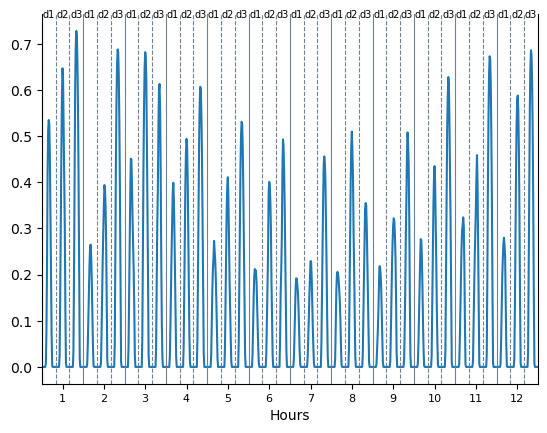

<Axes: xlabel='season'>

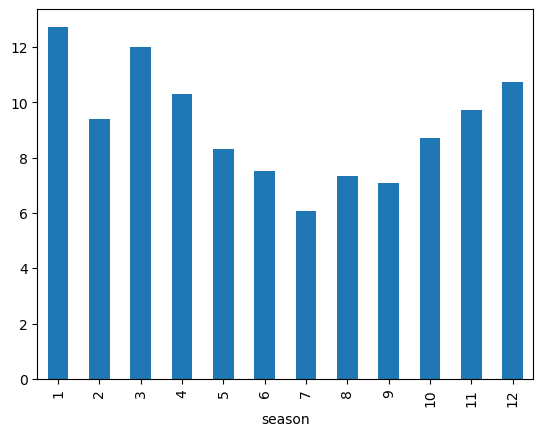

In [7]:
# Plot PV profile
path_file = os.path.join(main_folder, 'pVREProfile_{}.csv'.format(name_data))
df = pd.read_csv(path_file, index_col=[0, 1, 2, 3])
df = df.droplevel('zone', axis=0)
df = df.xs('PV', level='Power')
df = df.stack()
df.index.names = ['season', 'day', 'hour']
plot_dispatch(df)

df.groupby('season').sum().plot(kind='bar')


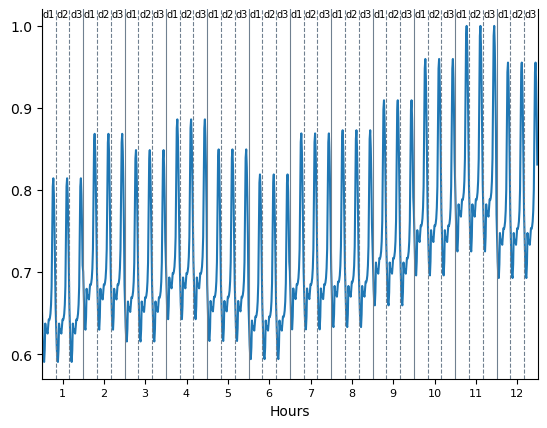

In [12]:
# Plot Demand profile
path_file = os.path.join(main_folder, 'pDemandProfile_{}.csv'.format(name_data))
df = pd.read_csv(path_file, index_col=[0, 1, 2])
df = df.droplevel('zone', axis=0)
df = df.stack()
df.index.names = ['season', 'day', 'hour']
plot_dispatch(df)

In [11]:
df

season  daytype  t01          
1       1        0.656730  t02    0.630684
                           t03    0.607479
                           t04    0.593175
                           t05    0.590509
                           t06    0.604878
                                    ...   
12      3        0.770465  t20    0.943641
                           t21    0.955322
                           t22    0.931375
                           t23    0.888414
                           t24    0.831072
Length: 828, dtype: float64